<a href="https://colab.research.google.com/github/Melvinmcrn/Project_ML_Soccer-world-cup-2018/blob/master/Soccer%20World%20Cup%202018%20Winner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
%matplotlib inline

# **Data**

there are 3 datasets here.<br>
1. **rankings**: FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a decent predictor of team performance<br>
2. **matches**: used to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match<br>
3. **world_cup**: upcoming matches

In [0]:
rankings = pd.read_csv('https://raw.githubusercontent.com/Melvinmcrn/Project_ML_Soccer-world-cup-2018/master/data/fifa_ranking.csv')
matches = pd.read_csv('https://raw.githubusercontent.com/Melvinmcrn/Project_ML_Soccer-world-cup-2018/master/data/results.csv')
world_cup = pd.read_csv('https://raw.githubusercontent.com/Melvinmcrn/Project_ML_Soccer-world-cup-2018/master/data/World%20Cup%202018%20Dataset.csv')

### **Prepare 'rankings'**

In [3]:
rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [4]:
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


### **Prepare 'matches'**

In [5]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [6]:
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### **Prepare 'world_cup'**

In [7]:
world_cup.head()

,Team,Group,Previous \nappearances,Previous \ntitles,Previous\n finals,Previous\n semifinals,Current \nFIFA rank,First match \nagainst,Match index,history with \nfirst opponent\n W-L,history with\n first opponent\n goals,Second match\n against,Match index.1,history with\n second opponent\n W-L,history with\n second opponent\n goals,Third match\n against,Match index.2,history with\n third opponent\n W-L,history with\n third opponent\n goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


In [8]:
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')
world_cup.head(10)

,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran
Spain,B,Portugal,Iran,Morocco
Morocco,B,Iran,Portugal,Spain
Iran,B,Morocco,Spain,Portugal
France,C,Australia,Peru,Denmark


# **Feature extraction**

In [0]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

In [10]:
rankings.head()

,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,2003-01-15,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
1,2003-01-16,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
2,2003-01-17,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
3,2003-01-18,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
4,2003-01-19,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0


In [11]:
# join the ranks
matches_rank = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches_rank.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0


In [12]:
matches_rank = matches_rank.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
matches_rank.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0


In [13]:
# feature generation
matches_rank['rank_difference'] = matches_rank['rank_home'] - matches_rank['rank_away']
matches_rank['average_rank'] = (matches_rank['rank_home'] + matches_rank['rank_away'])/2
matches_rank['point_difference'] = matches_rank['weighted_points_home'] - matches_rank['weighted_points_away']
matches_rank['score_difference'] = matches_rank['home_score'] - matches_rank['away_score']
matches_rank['is_won'] = matches_rank['score_difference'] > 0 # take draw as lost
matches_rank['is_stake'] = matches_rank['tournament'] != 'Friendly'
matches_rank.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0,37.0,40.5,0.0,2,True,True
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0,-6.0,11.0,0.0,0,False,False
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0,-59.0,64.5,0.0,5,True,True
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0,-21.0,75.5,0.0,1,True,False
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0,62.0,36.0,0.0,-2,False,True


In [0]:
# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches_rank['rest_days'] = matches_rank.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

In [0]:
# I tried earlier the team as well but that did not make a difference either
matches_rank['wc_participant'] = matches_rank['home_team'] * matches_rank['home_team'].isin(world_cup.index.tolist())
matches_rank['wc_participant'] = matches_rank['wc_participant'].replace({'':'Other'})
matches_rank = matches_rank.join(pd.get_dummies(matches_rank['wc_participant']))

In [19]:
matches_rank.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake,rest_days,wc_participant,Argentina,Australia,Belgium,Brazil,Colombia,Costa Rica,Croatia,Denmark,Egypt,England,France,Germany,Iceland,Iran,Japan,Korea Republic,Mexico,Morocco,Nigeria,Other,Panama,Peru,Poland,Portugal,Russia,Saudi Arabia,Senegal,Serbia,Spain,Sweden,Switzerland,Tunisia,Uruguay
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0,37.0,40.5,0.0,2,True,True,30.0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0,-6.0,11.0,0.0,0,False,False,30.0,Brazil,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0,-59.0,64.5,0.0,5,True,True,30.0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0,-21.0,75.5,0.0,1,True,False,30.0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0,62.0,36.0,0.0,-2,False,True,30.0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Visualize**

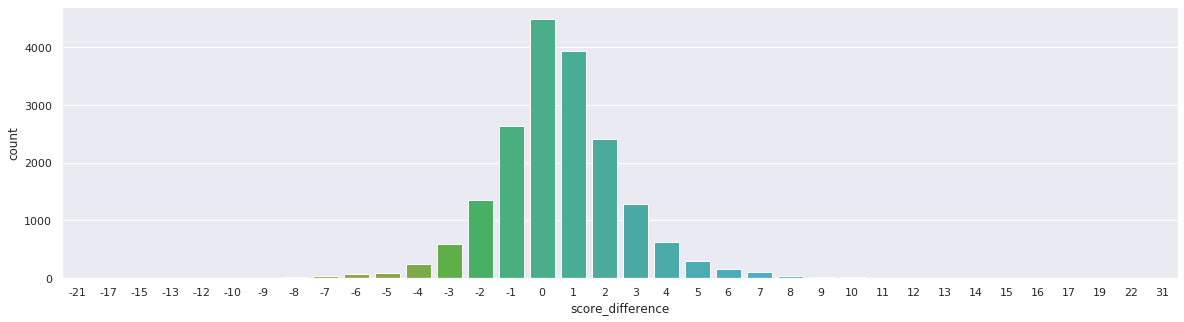

In [23]:
fig,ax0 = plt.subplots(figsize=(20,5))
sb.countplot(x='score_difference', data=matches_rank)

# **Modeling**

using simple Logistic regression